In [ ]:
# instalação do Weights & Biases
!pip install wandb

In [ ]:
# importando bibliotecas
import wandb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pickle
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# wandb login
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Buscando artefatos no wandb

In [ ]:
# inicializando uma run no wandb
run = wandb.init(project="Breast Cancer TCC", job_type="train_model")

wandb: Currently logged in as: valmirfrancisco1. Use `wandb login --relogin` to force relogin


In [ ]:
# buscando artefatos de treino
artifact = run.use_artifact('valmirfrancisco1/Breast Cancer TCC/label_data_train:latest', type='split_data').file()
artifact2 = run.use_artifact('valmirfrancisco1/Breast Cancer TCC/img_data_train:latest', type='split_data').file()
df = pd.read_csv(artifact)
labels = df["cancer"]
data_img = np.load(artifact2)

In [ ]:
# vendo os valores dos rótulos
print(len(labels))
count_zeros = np.count_nonzero(labels == 0)
print(count_zeros)
count_ones = np.count_nonzero(labels == 1)
print(count_ones)

1852
926
926


# Separando dados de treino e dados de validação

In [ ]:
# dividindo valores de treino e validação
X_train, X_test, y_train, y_test = train_test_split(data_img, labels, test_size=0.2, random_state=42, stratify=labels)

# Criando o nosso modelo

In [ ]:
# Arquitetura VGG-16 com input shape alterado

model = tf.keras.Sequential([
    # PARTE DA CONVULUÇÃO
    # faz operações de convolução com 32 filtros para detecção de padrões em cada 4 pixels (2x2)
    # o input_shape significa que ele espera utilizar imagens de 128px por 128px no padrão RGBA
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    # a operação de max pooling tem o efeito de reduzir a resolução espacial da entrada, mantendo apenas os valores máximos dentro da janela de pooling.
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # PARTE DA REDE NEURAL

    # a camada Flatten em uma rede neural é usada para converter dados de entrada multidimensionais em uma única dimensão
    Flatten(),
    # camadas internas ou escondidas da rede neural
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    # a ideia por trás do dropout é desativar aleatoriamente uma fração dos neurônios durante o treinamento, evitando assim o overfitting
    Dropout(0.5),
    # Camada de saida de 2 neuronios (negativo ou positivo) com função softmax que nos dá probabiulidade de pertencer a cada classe
    Dense(2, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [ ]:
# compila o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=('accuracy'))

In [ ]:
# utilizando earlystopping para interromper o treinamento se a acurácia na validação não estiver aumentando mesmo após certo número de epochs (patience)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 30)

In [ ]:
# salvar o melhor modelo com maior acurácia na validação
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="breast_cancer_weights.keras", verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# treinamento do modelo e o histórico dos resultados desse treinamento
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=64, callbacks=[checkpointer, earlystopping])

Epoch 1/150
24/24 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.4963
Epoch 1: val_accuracy improved from -inf to 0.49865, saving model to breast_cancer_weights.keras
24/24 [==============================] - 42s 2s/step - loss: 0.6992 - accuracy: 0.4963 - val_loss: 0.6936 - val_accuracy: 0.4987
Epoch 2/150
24/24 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4916
Epoch 2: val_accuracy improved from 0.49865 to 0.50135, saving model to breast_cancer_weights.keras
24/24 [==============================] - 32s 1s/step - loss: 0.6936 - accuracy: 0.4916 - val_loss: 0.6933 - val_accuracy: 0.5013
Epoch 3/150
24/24 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.4848
Epoch 3: val_accuracy did not improve from 0.50135
24/24 [==============================] - 20s 851ms/step - loss: 0.6955 - accuracy: 0.4848 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 4/150
24/24 [==============================] - ETA: 0s - loss: 0.6939 -

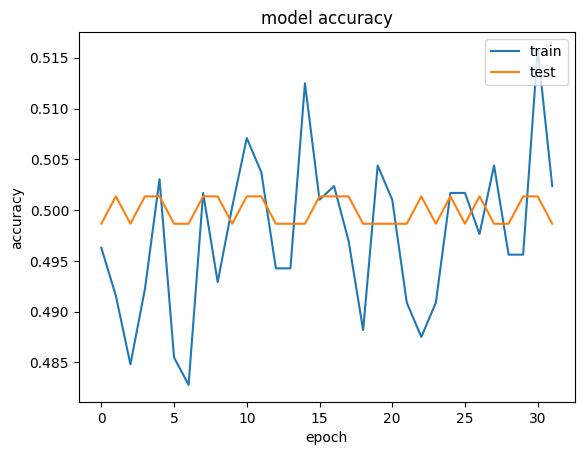

In [ ]:
# gráfico da acurácia durante o treino
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

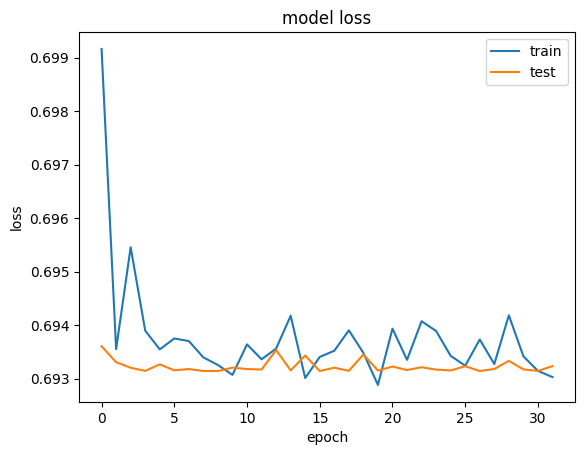

In [ ]:
# gráfico do loss durante o treino
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Criando nossa classe de pipeline

In [ ]:
# arquivo de classes personalizada do pipeline
%%file imageProcessor.py

import numpy as np
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ImageProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        processed_images = []

        for item in X:
            if isinstance(item, np.ndarray):
                # Se for um numpy array, assumimos que já está na forma correta
                im = item.astype('float32')
                # Verificar se os valores já foram divididos por 255
                if im.max() > 1.0:
                    # Normalizar os valores dos pixels
                    im /= 255.0
            elif isinstance(item, Image.Image):
                # Se for uma instância de Image (Pillow), aplicamos as transformações
                im = item.copy()
                # Converter a imagem para o modo RGBA se não estiver nesse formato
                if im.mode != 'RGB':
                    im = im.convert('RGB')
                # Redimensionar a imagem para o tamanho desejado
                im = im.resize(self.target_size)
                # Converter a imagem para um array numpy de float32
                im = np.array(im, dtype='float32')
                # Verificar se os valores já foram divididos por 255
                if im.max() > 1.0:
                    # Normalizar os valores dos pixels
                    im /= 255.0
            else:
                raise ValueError("O tipo de entrada não é suportado.")

            # Adicionar a imagem processada à lista de resultados
            processed_images.append(im)

        return np.array(processed_images)

Writing imageProcessor.py


In [ ]:
# importar a classe do arquivo Python que criamos
from imageProcessor import ImageProcessor

In [ ]:
modelo_carregado = tf.keras.models.load_model('breast_cancer_weights.keras')

In [ ]:
# criando um pipeline com normalizador e o modelo treinado
pipeline = Pipeline([
    ('normalizer', ImageProcessor(target_size=(224, 224))),
    ('model', modelo_carregado)
])

## Usando Pipeline

In [ ]:
predictions = pipeline.predict(X_test)

12/12 [==============================] - 13s 536ms/step


In [ ]:
predict = []
for i in predictions:
    predict.append(np.argmax(i))

In [ ]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       186
           1       0.00      0.00      0.00       185

    accuracy                           0.50       371
   macro avg       0.25      0.50      0.33       371
weighted avg       0.25      0.50      0.33       371



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Adicionando o pipeline no wandb

In [ ]:
from joblib import dump, load

In [ ]:
dump(pipeline, 'pipe.joblib')

['pipe.joblib']

In [ ]:
# criando um artefato no wandb
artifact = wandb.Artifact(name="animation_model_pipeline",
                                type="pipeline",
                                description="pipeline of the trained model",
      )

# adiciona o arquivo no artefato
artifact.add_file("/content/pipe.joblib")
# salva o artefato no wandb
wandb.run.log_artifact(artifact)

<Artifact animation_model_pipeline>

# Put the python class into wandb

In [ ]:
# criando um artefato no wandb
artifact = wandb.Artifact(name="imageProcessor_class",
                                type="python",
                                description="class needed to use in transform of our pipeline",
      )

# adiciona o arquivo no artefato
artifact.add_file("/content/imageProcessor.py")
# salva o artefato no wandb
wandb.run.log_artifact(artifact)

<Artifact imageProcessor_class>

In [ ]:
# termina a run
run.finish()